In [158]:
import torch
import torch.nn as nn
import torchvision
import PIL
import matplotlib.pyplot as plt
from torchvision import transforms


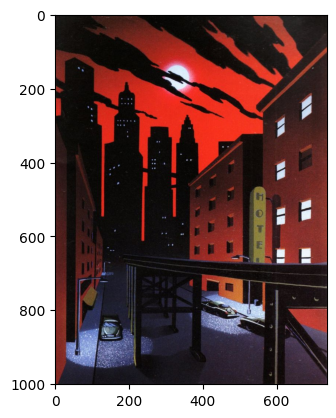

In [159]:
# read style image
style_img = PIL.Image.open('/content/style2.jpg')

# show style image with matplotlib
plt.imshow(style_img)
plt.show()

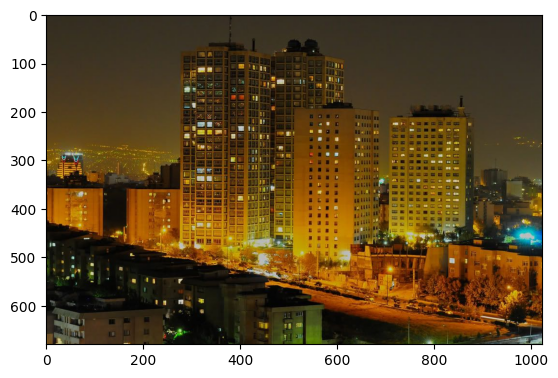

In [160]:
# read content image
content_img = PIL.Image.open('/content/content6.jpg')

# resize style image to match content image size
style_img = style_img.resize(content_img.size)

# show content image with matplotlib
plt.imshow(content_img)
plt.show()

In [161]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.selected_features = ['0', '5', '10', '19', '28']
        self.model = torchvision.models.vgg19(pretrained=True).features

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.selected_features:
                features.append(x)
        return features

In [162]:
criteria = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 1000
alpha = 1
beta = 40000

model = VGG().to(device).eval()
final_image_size = 512
loader = transforms.Compose([
                             transforms.Resize(final_image_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

content_img = loader(content_img).unsqueeze(0).to(device)
style_img = loader(style_img).unsqueeze(0).to(device)
target_img = content_img.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target_img], lr=0.01)


In [163]:
def get_content_loss(content, target):
    return torch.mean((content - target) ** 2)

def get_gram_matrix(input, channel, height, width):
    input = input.view(channel, height * width)
    G = torch.mm(input, input.t())
    return G

def get_style_loss(target, style):
    _, channel, height, width = target.size()
    G_target = get_gram_matrix(target, channel, height, width)
    G_style = get_gram_matrix(style, channel, height, width)
    return torch.mean(((G_target - G_style) ** 2)/(channel * height * width))


In [164]:
def save_image(path, image):
    denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    img = image.clone().squeeze()
    img = denormalization(img).clamp(0, 1)
    torchvision.utils.save_image(img, path)

epoch: 0, content loss: 0.0, style loss: 1128.59814453125


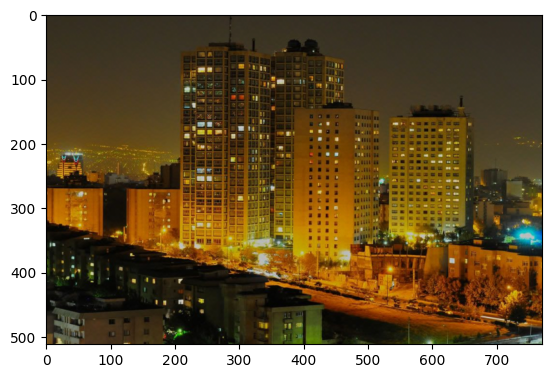

epoch: 50, content loss: 21.288808822631836, style loss: 163.09597778320312
epoch: 100, content loss: 24.617107391357422, style loss: 71.58318328857422


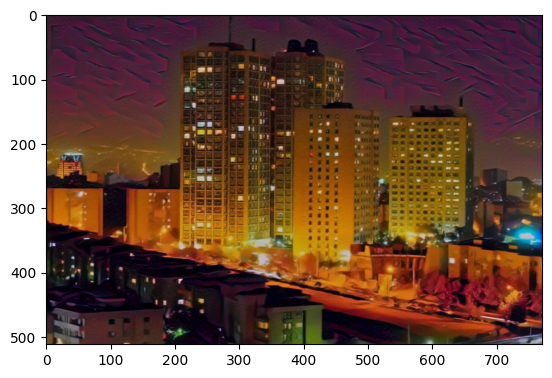

epoch: 150, content loss: 26.361572265625, style loss: 45.09685516357422
epoch: 200, content loss: 27.56012535095215, style loss: 34.30036163330078


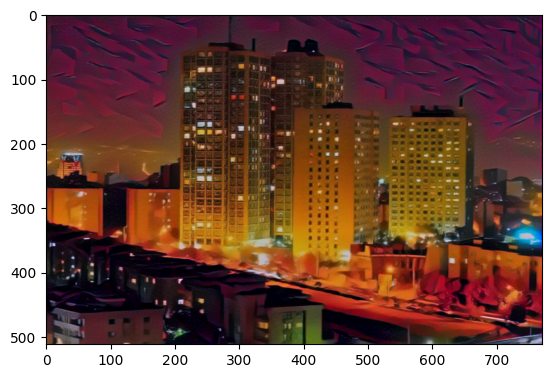

epoch: 250, content loss: 28.44654655456543, style loss: 27.547513961791992
epoch: 300, content loss: 29.146577835083008, style loss: 22.903839111328125


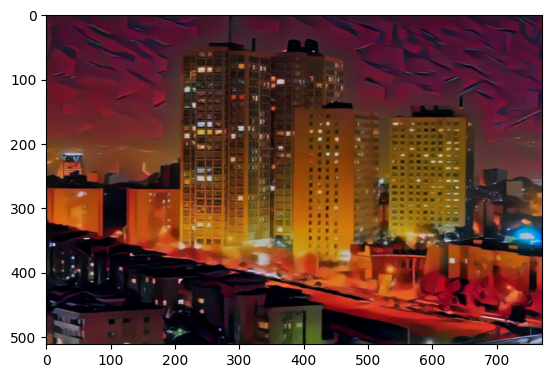

epoch: 350, content loss: 29.71518898010254, style loss: 19.522981643676758
epoch: 400, content loss: 30.210880279541016, style loss: 16.927839279174805


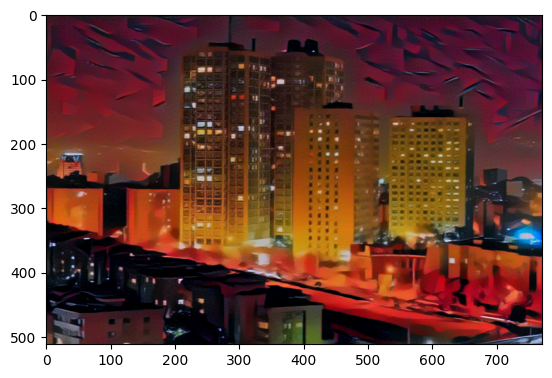

epoch: 450, content loss: 30.633953094482422, style loss: 14.842411994934082
epoch: 500, content loss: 31.00627899169922, style loss: 13.103334426879883


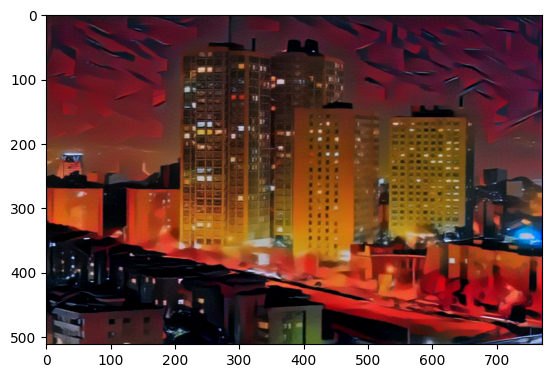

epoch: 550, content loss: 31.339374542236328, style loss: 11.620518684387207
epoch: 600, content loss: 31.634735107421875, style loss: 10.337705612182617


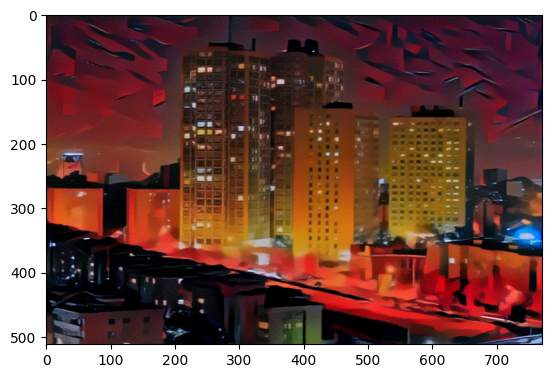

epoch: 650, content loss: 31.92076873779297, style loss: 9.216524124145508
epoch: 700, content loss: 32.177978515625, style loss: 8.234801292419434


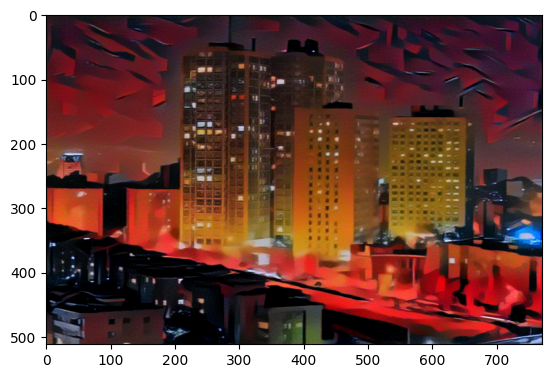

epoch: 750, content loss: 32.407325744628906, style loss: 7.372491836547852
epoch: 800, content loss: 32.618255615234375, style loss: 6.617396831512451


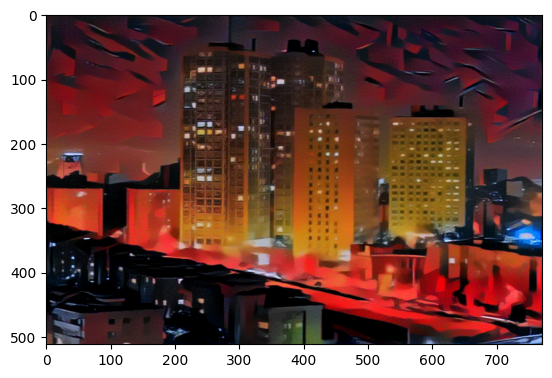

epoch: 850, content loss: 32.809478759765625, style loss: 5.958625316619873
epoch: 900, content loss: 32.9896354675293, style loss: 5.382953643798828


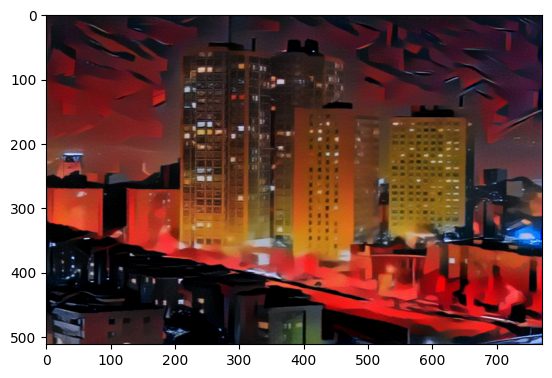

epoch: 950, content loss: 33.15557861328125, style loss: 4.878669738769531


In [165]:
for epoch in range(n_epochs):

  target_feature = model(target_img)
  content_feature = model(content_img)
  style_feature = model(style_img)

  style_loss = 0
  content_loss = 0

  for target, content, style in zip(target_feature, content_feature, style_feature):
    content_loss += get_content_loss(target, content)
    style_loss += get_style_loss(target, style)

  total_loss = alpha*content_loss+beta*style_loss

  optimizer.zero_grad()

  total_loss.backward()

  optimizer.step()

  if epoch%50 == 0:

    print(f'epoch: {epoch}, content loss: {content_loss.item()}, style loss: {style_loss.item()}')

  if epoch%100 == 0:
    save_image(f'output_{epoch}.png', target_img)
    plt.imshow(PIL.Image.open(f'output_{epoch}.png'))
    plt.show()

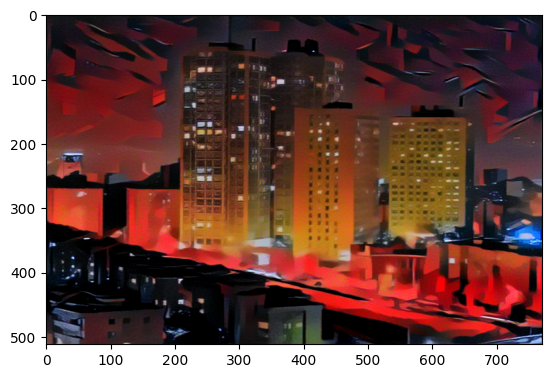

In [166]:
save_image(f'output_{epoch}.png', target_img)
plt.imshow(PIL.Image.open(f'output_{epoch}.png'))
plt.show()